In [11]:
#Import library
import os
import numpy as np

#Import library tensorflow dan modul keras yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

#Penjelasan
# layers digunakan untuk menambahkan lapisan ke dalam model
# load_img digunakan untuk memuat gambar
# ImageDataGenerator digunakan untuk melakukan augmentasi pada gambar
# Sequential digunakan untuk membuat model secara berurutan
# Conv2D digunakan untuk membuat lapisan konvolusi
# MaxPooling2D digunakan untuk melakukan pooling pada lapisan konvolusi
# Dense digunakan untuk membuat lapisan fully connected
# Dropout digunakan untuk menghindari overfitting
# Flatten digunakan untuk membuat lapisan menjadi flat (rata) menjadi vektor 1 dimensi


In [13]:
count = 0 #digunakan untuk menghitung jumlah gambar
dirs = os.listdir(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Biji_strawberry Folder has 100 Images
tumbuhan_dewasa Folder has 102 Images
tunas Folder has 100 Images
Images Folder has 302 Images


In [16]:
# Parameter
base_dir = r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata' #direktori folder dataset
img_size = 180 #mengubah ukuran gambar menjadi 180
batch = 32 #jumlah sample (gambar) yang akan diproses pada satu kali iterasi
validation_split = 0.1 #data pelatihan yang akan digunakan sebagai data validasi

In [17]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, #path direktori, subfolder dianggap sebagai label
    seed=123, #untuk memastikan proses pemisahan data selalu konsisten (random_state)
    image_size=(img_size, img_size), #ukuran gambar diubah (resize) menjadi 180x180 pixel
    batch_size=batch, #jumlah gambar yang akan dikelompokkan 
)

Found 284 files belonging to 3 classes.


In [18]:
#mendapatkan nama kelas dari dataset 
class_names = dataset.class_names #dataset.class_names akan mengambil daftar nama kelas berdasarkan subfolder di dalam direktori
print("Class Names:", class_names)

Class Names: ['Biji_strawberry', 'tumbuhan_dewasa', 'tunas']


In [19]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count


print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 9
Train Images: 9
Validation Images: 0


In [20]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

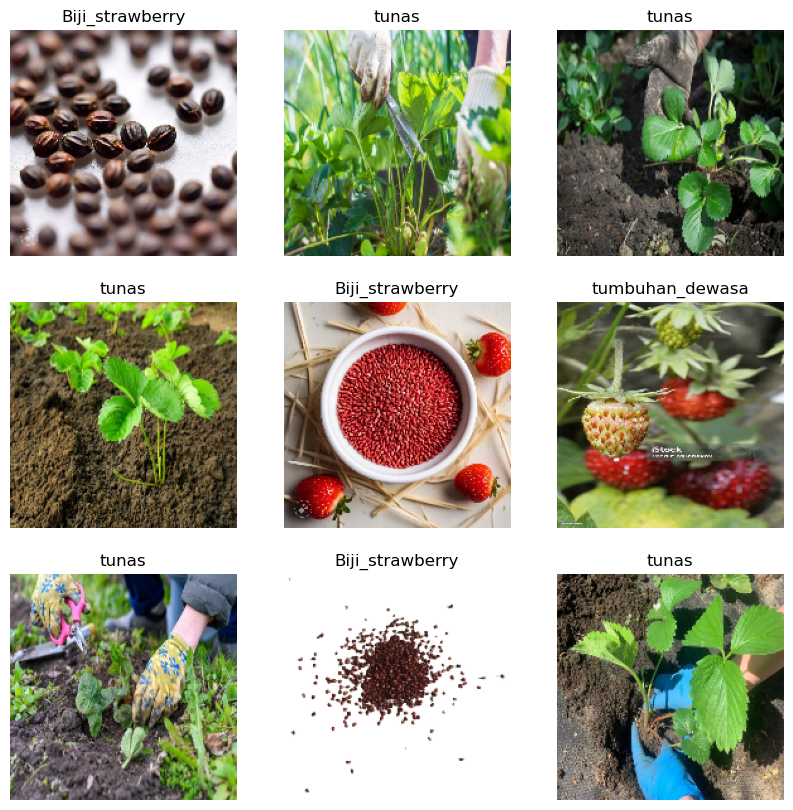

In [21]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) #membuat figure dengan ukuran 10x10 inchi untuk menampilkan gambar

for images, labels in train_ds.take(1): #mengambil 1 batch pertama dari train_ds
    for i in range(9):
        plt.subplot(3,3, i+1) #menyiapkan subplot dengan grid 3x3 dan menempatkan gambar pada posisi i+1
        plt.imshow(images[i].numpy().astype('uint8')) #menampilkan gambar dan mengonversi ke tipe uint8
        plt.title(class_names[labels[i]]) #menampilkan judul gambar sesuai dengan nama kelas
        plt.axis('off') #menonaktifkan sumbu pada gambar agar tidak terlihat

In [22]:
import numpy as np

# Tampilkan gambar dengan shape (32, 180, 180, 3)
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  # Output: (32, 180, 180, 3)
    #32: Jumlah gambar dalam batch.
    #180: Lebar gambar dalam piksel
    #180: Tinggi gambar dalam piksel
    #3: Jumlah channel gambar (RGB)

(32, 180, 180, 3)


In [23]:
#Mengatur AUTOTUNE untuk pemrosesan data otomatis oleh tensorflow
#AUTOTUNE digunakan untuk memungkinkan tensorflow mengoptimalkan jumlah thread secara otomatis saat memproses data
AUTOTUNE = tf.data.AUTOTUNE

In [24]:
#mengoptimalkan dataset pelatihan (train_ds)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
#cache digunakan untuk menyimpan dataser di memori agar lebih cepat diakses
#shuffle mengacak data dalam batch agar model tidak terlalu terlatih pada urutan tertentu
#prefetch untuk menyiapkan data batch berikutnya secara otomatis

In [25]:
#mengoptimalkan dataset validasi (val_ds) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [26]:
data_augmentation = Sequential([
    layers.RandomFlip("harizontal", input_shape = (img_size,img_size,3)), #membalik gambar secara horizontal
    layers.RandomRotation(0.1), #merotasi gambar secara acak dalam kisaran 0°-36° (0.1 * 360)
    layers.RandomZoom(0.1) #melakukan zoom in/zoom out secara acak dengan rentang 10%
])

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


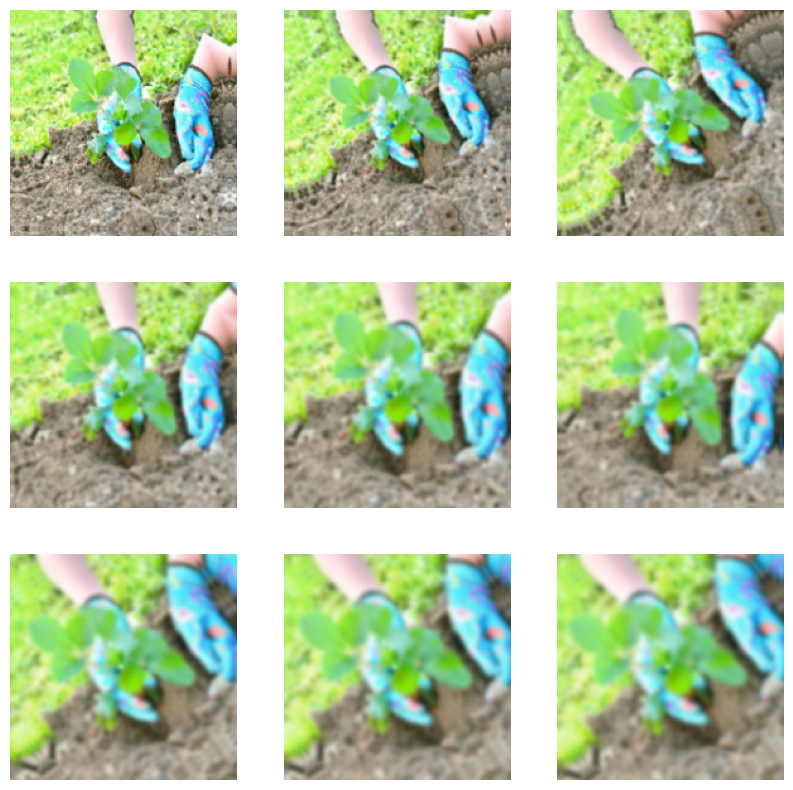

In [27]:
#sama seperti sebelumnya, code ini digunakan untuk menampilkan gambar dari data_augmentation
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [28]:
#import library yang dibutuhkan
from tensorflow.keras.applications import VGG16 #digunakan untuk memanfaatkan model yang sudah dilatih sebelumnya untuk pengenalan gambar
from tensorflow.keras.models import Model #digunakan untuk membuat dan mengonfigurasi arsitektur model

#membuat model dengan bobot yang telah dilatih sebelumnya
#include_top=False berarti tidak menggunakan lapisan klasifikasi dari mobilenet hanya bagian ekstraksi fitur
base_model = VGG16(include_top=False, input_shape=(img_size, img_size, 3))

#membuka (unfreeze beberapa lapisan untuk proses fine tuning)
base_model.trainable = True #seluruh model bisa dilatih
fine_tune_at = len(base_model.layers) // 2  #menentukan bahwa setengah lapisan terakhir akan di unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False #mengunci (freeze) lapisan pertama hingga setengah bagian pertama agar tidak dilatih kembali

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [29]:
from tensorflow.keras.optimizers import Adam #untuk mengoptimalkan proses pelatihan model

#mengkompilasi model dengan optimizer, loss function, dan metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4), #menggunakan optimizer Adam dengan learning rate 0.0001
    loss='sparse_categorical_crossentropy', #untuk klasifikasi multi-kelas
    metrics=['accuracy'] #akurasi digunakan sebagai metrik evaluasi
)


In [30]:
#menampilkan ringkasan dari model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 13,635,331 (52.01 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [31]:
#early stopping digunakan untuk menghentikan pelatihan lebih awal jika model tidak ada peningkatan
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=4,
                               mode='max')

#melatih model menggunakan data latih dan validasi dengan early stopping
history= model.fit(train_ds, #data pelatihan yang telah disiapkan
                   epochs=30, # jumlah maksimal epoch
                   validation_data=val_ds,  #data validasi untuk mengevaluasi model pada setiap epoch
                   callbacks=[early_stopping]) #menambahkan early stopping ke dalam callback untuk pelatihan

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4907 - loss: 0.9231
Epoch 2/30


c:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8939 - loss: 0.2877
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9363 - loss: 0.1904
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9158 - loss: 0.2226
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9355 - loss: 0.2018
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9604 - loss: 0.1067
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9725 - loss: 0.0645
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9778 - loss: 0.0687
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9809 - loss: 0.0428
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9908 - loss: 0.0157
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 6.1917e-04
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9968 - loss: 0.0246
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9978 - loss: 0.0120
Epoch 14/30
9/9 ━━━

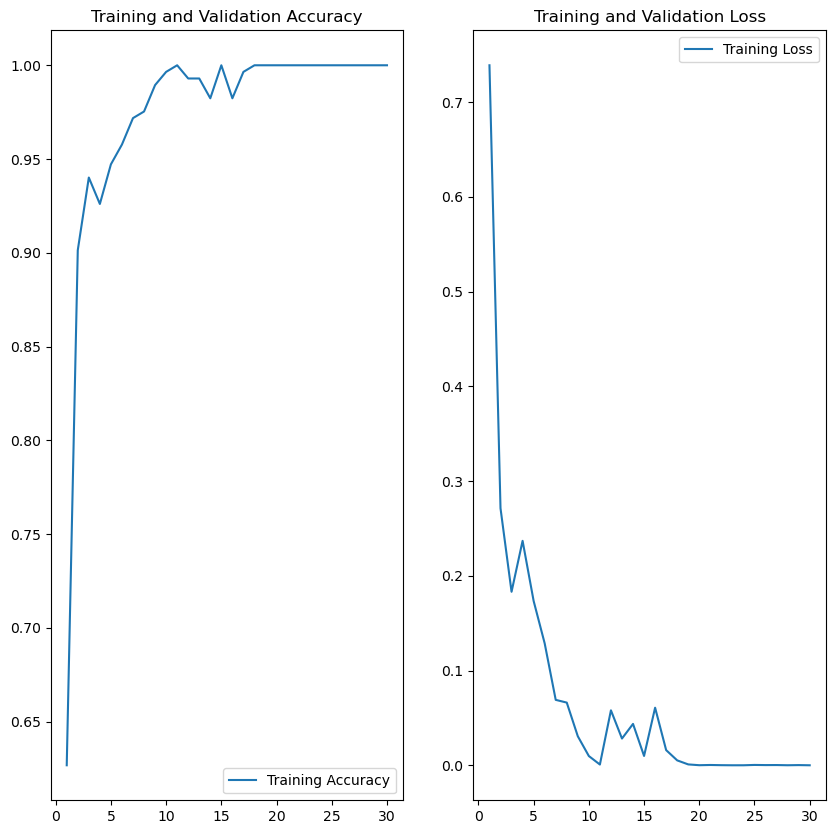

In [32]:
import matplotlib.pyplot as plt

# Mengatur rentang epoch
epochs_range = range(1, len(history.history['loss']) + 1)

# Membuat plot
plt.figure(figsize=(10, 10))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Menampilkan plot
plt.show()

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# 1. Load VGG16 Pretrained Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [34]:
for layer in base_model.layers:
    layer.trainable = False

In [35]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes (modify based on your dataset)
])

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Data Preparation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata',  # Update with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 228 images belonging to 3 classes.
Found 56 images belonging to 3 classes.


In [40]:
model.save('models/vgg16_final_model.h5')

In [44]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('models/vgg16_best_model.keras', save_best_only=True)  # Ubah ke .keras
]

# Simpan model akhir dengan .keras
model.save('models/vgg16_final_model.keras')

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

#memuat model yang sudah dilatih
model = load_model(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\models\vgg16_final_model.h5')  # Ganti dengan path model Anda
class_names = ['Matang', 'Mentah'] #kelas yang ada pada model

#fungsi untuk mengklasifikasikan gambar dan menyimpan gambar asli
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) #membuat gambar dari path dan mnegubah ukurannya menjadi 180x180 pixel
        input_image_array = tf.keras.utils.img_to_array(input_image) #mengubah gambar jadi array numpy agar bisa di proses model
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  #menambahkan dimensi batch agar sesuai dengan input model
                                                                    #dimensi menjadi (1, 180, 180, 3)

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim) #melakukan prediksi pada gambar yang telah diproses
        result = tf.nn.softmax(predictions[0]) #menghitung hasil prediksi menggunakan softmax untuk mendapatkan probabilitas tiap kelas
        class_idx = np.argmax(result) #menemukan indeks kelas dengan probabilitas tertinggi
        confidence = np.max(result) * 100 #menghitung confidence dalam persentase

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}") #menampilkan nama kelas yang diprediksi 
        print(f"Confidence: {confidence:.2f}%") #menampilkan nilai confidence

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path) #membuka gambar yang ada di path
        input_image.save(save_path) #menyimpan gambar asli ke dalam path yang telah ditentukan

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
result = classify_images(r'D:\Semester 5\Pembelajaran Mesin Dan Mendalam\UAS\train_data\Dewasa_strawberry\cara-menanam-strawberry-dari-biji.jpg', save_path='matang.jpg')
print(result)


Terjadi kesalahan: [Errno 2] No such file or directory: 'D:\\Semester 5\\Pembelajaran Mesin Dan Mendalam\\UAS\\train_data\\Dewasa_strawberry\\cara-menanam-strawberry-dari-biji.jpg'


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


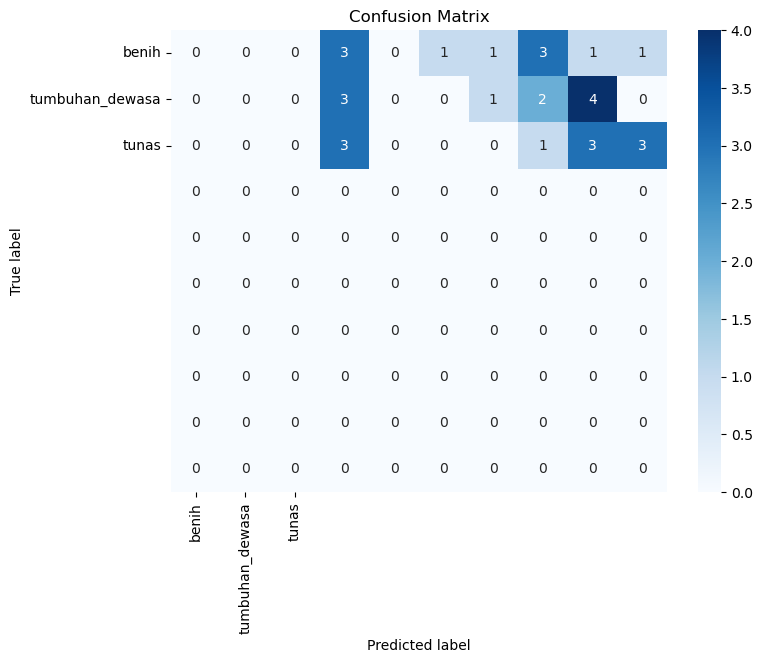

Confusion Matrix:
 [[0 0 0 3 0 1 1 3 1 1]
 [0 0 0 3 0 0 1 2 4 0]
 [0 0 0 3 0 0 0 1 3 3]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Akurasi: 0.0
Presisi: [nan nan nan  0. nan  0.  0.  0.  0.  0.]
Recall: [ 0.  0.  0. nan nan nan nan nan nan nan]
F1 Score: [nan nan nan nan nan nan nan nan nan nan]


In [46]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Memuat model VGG16 yang telah dilatih sebelumnya
vgg16_model = load_model(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\models\vgg16_final_model.h5')  # Ganti dengan path sesuai sistem Anda

# Memuat data uji
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',  # Ganti dengan path ke direktori data uji
    labels='inferred',  # Label otomatis dari subfolder
    label_mode='categorical',  # Menghasilkan label dalam bentuk one-hot encoding
    batch_size=32,  # Ukuran batch untuk pemrosesan
    image_size=(224, 224)  # Ukuran gambar yang sesuai untuk VGG16
)

# Prediksi menggunakan model
y_pred = vgg16_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  # Konversi prediksi menjadi kelas

# Ekstrak label sebenarnya dari test_data dan konversi ke indeks kelas
true_labels = []  # Menyimpan label asli dalam bentuk indeks
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  # Konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels)  # Mengubah list ke tensor

# Membuat confusion matrix
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

# Menghitung akurasi
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

# Menghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

# Menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_names,  # Label prediksi
            yticklabels=test_data.class_names)  # Label asli
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())